In [3]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# **1. Исследование данных**

## **1.1 Сбор данных**

In [4]:
df = pd.read_csv('data/dictionery of regions/Code of regions.zip', sep=';', usecols=[1])
df.columns=['name']
df.name = df.name.astype('string')
df.sort_values(by='name', inplace=True)
dc = df.set_index(df.name.apply(lambda x: re.search(r'\w+',x[0:7])[0].lower()))
dc = dc.name.to_dict()
dc['ямало'] = 'Ямало-Ненецкий АО'
dc['крым'] = 'Республика Крым'
dc['севасто'] = 'Севастополь'
dc['москва'] =  'Москва'
dc['ненецки'] = 'Ненецкий АО'
dc

{'адыгея': 'Адыгея, республика',
 'алтай': 'Алтай, республика',
 'алтайск': 'Алтайский край',
 'амурска': 'Амурская область',
 'арханге': 'Архангельская область',
 'астраха': 'Астраханская область',
 'башкорт': 'Башкортостан, республика',
 'белгоро': 'Белгородская область',
 'брянска': 'Брянская область',
 'бурятия': 'Бурятия, республика',
 'владими': 'Владимирская область',
 'волгогр': 'Волгоградская область',
 'вологод': 'Вологодская область',
 'воронеж': 'Воронежская область',
 'дагеста': 'Дагестан, республика',
 'еврейск': 'Еврейская АО',
 'забайка': 'Забайкальский край',
 'ивановс': 'Ивановская область',
 'ингушет': 'Ингушетия, республика',
 'иркутск': 'Иркутская область',
 'кабарди': 'Кабардино-Балкарская республика',
 'калинин': 'Калининградская область',
 'калмыки': 'Калмыкия, республика',
 'калужск': 'Калужская область',
 'камчатс': 'Камчатский край',
 'карачае': 'Карачаево-Черкесская республика',
 'карелия': 'Карелия, республика',
 'кемеров': 'Кемеровская область',
 'кировск'

In [5]:
def d1(file, to_drop=[], sheet=0,head=0, sort=True, usecols=None, rolling=False, sep=None, decimal='.'):
    """
    Функция считывает данные из файла, преобразовывает название региона в соответствии со справочником регионов,
    производит необходимые форматирования
    
    Args:
        file - имя файла
        to_drop - список регионов для удаления
        sheet - номер страницы
        head - строка заголовк таблицы
        sort - необходимость сортировки
        usecols  - используемые столбцы
        rolling -использование смещение данных
        sep - разделитель мужду данными
        decimal - деятичная запятая
    
    Returns: отформатированный Frame
    """    
    def f1(x):
        x = x.strip()
        if re.search(r'район|федеральный|!|республики|входящий|сельсовет', x): return ''
        else:
            x = re.sub(r'\bb','в', x)
            y = re.sub(r'республик(а|и)|респ.|г\.|\bгород\b|область|федерального значения', '',x).strip()
            return y
        
    def f2(x):
        return re.search(r'\w{,7}',x[0:7])[0]
    
    if file[-3:] == 'csv':
        df=pd.read_csv(file, usecols=usecols, sep=sep, decimal=decimal)
    else:
        df= pd.read_excel(file, sheet_name=sheet, header=head, usecols=usecols)
    
    if rolling:
        df[df.columns.values[1:]] = df[df.columns.values[1:]].fillna(0).shift(-1)    
            
    df.rename({df.columns[0]: 'region'}, axis=1, inplace=True)
    #(df[df['region'].isin(to_drop)])
    df['region'] = df['region'].astype('string').str.strip()
    
    df = df[~df['region'].isin(to_drop)].copy()
    df['region'] = df['region'].str.lower()
   
    df['region'] = df['region'].apply(f1)
    df['region'] = df['region'].apply(f2)
    er = set(dc.keys()).difference(set(df['region']))
    if len(er)!=0: print('!!!', er)
    df['region']=df['region'].str.lower().map(dc)
    df = (df.dropna(subset='region').set_index('region'))
    try:
        df.iloc[:,1:] = df.iloc[:,1:].astype('float')
    finally:
        
    #df = (df.set_index('region3'))
        return (df.sort_index())  if sort else df
    #return (df.set_index('region3').sort_index()) 
 

### **1.1.1 Доходы населения**

In [6]:
f = 'data/social_russia_data/cash_real_income_wages_2015_2020.xlsx'
per_capita = d1(f, to_drop = ['Архангельская область', 'Тюменская область'], sheet=0)
real_incomes = d1(f, to_drop = ['Архангельская область', 'Тюменская область'], sheet=1)
formal_wage = d1(f, to_drop = ['Архангельская область', 'Тюменская область'],  sheet=2)
real_pay = d1(f, to_drop = ['Архангельская область', 'Тюменская область'], sheet=3)
per_capita = per_capita[2020]
per_capita.name = 'per_capita'
display('Среднедушевые доходы', per_capita.head())
#display('Реальные доходы населения', real_incomes.head())
#display('Формальная зарплата', formal_wage.head())
#display('Реальная зарплата', real_pay.head())


'Среднедушевые доходы'

region
Адыгея, республика       30293.0
Алтай, республика        21677.0
Алтайский край           23864.0
Амурская область         35499.0
Архангельская область    34852.0
Name: per_capita, dtype: float64

### **1.1.2 Cмертность детей на первом году жизни**

In [7]:
file='data/social_russia_data/child_mortality_rural_1990_2021.xls'
to_dr=[
        'Архангельская область (кроме Ненецкого автономного округа)',
        'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    ]
rural = d1(file, to_drop = ['Архангельская область', 'Тюменская область'], head=2)#, skipfooter=13)#, usecols='A, D:AI')
file = 'data/social_russia_data/child_mortality_urban_1990_2021.xls'
urban = d1(file, to_drop = to_dr, head=2)
#display('Сельская местность -Число умерших на первом году жизни детей за год (человек, значение показателя за год)', rural.head())
#display('Город- Число умерших на первом году жизни детей за год (человек, значение показателя за год)', urban.head())
mortality = rural.add(urban)['2020']
mortality.name = 'mortality'
display('Общая смертность',mortality.head())

'Общая смертность'

region
Адыгея, республика       14.0
Алтай, республика        22.0
Алтайский край           97.0
Амурская область         42.0
Архангельская область    31.0
Name: mortality, dtype: float64

### **1.1.3 Инвалидность**

In [8]:
file = 'data/social_russia_data/disabled_total_by_age_2017_2022.csv'
disabled = d1(file, head=2,decimal='.')#, usecols=[i for i in range(0,7)])#, skipfooter=13)#, usecols='A, D:AI')
disabled#.head()

/tmp/ipykernel_164448/2674328442.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df=pd.read_csv(file, usecols=usecols, sep=sep, decimal=decimal)


,total,18_30,31_40,41_50,51_60,60_,date
region,,,,,,,
"Адыгея, республика",32907.0,1445.0,2391.0,3693.0,6662.0,18716.0,2020-04-01
"Адыгея, республика",31946.0,1441.0,2365.0,3711.0,6279.0,18150.0,2021-07-01
"Адыгея, республика",33971.0,1505.0,2511.0,3821.0,7084.0,19050.0,2018-04-01
"Адыгея, республика",33996.0,1494.0,2524.0,3844.0,7092.0,19042.0,2018-05-01
"Адыгея, республика",31949.0,1430.0,2370.0,3697.0,6303.0,18149.0,2021-06-01
...,...,...,...,...,...,...,...
Ярославская область,104960.0,2784.0,5170.0,7448.0,14952.0,74606.0,2018-10-01
Ярославская область,109731.0,3024.0,5185.0,7522.0,16104.0,77896.0,2017-08-01
Ярославская область,96403.0,2658.0,5068.0,7457.0,13210.0,68010.0,2020-12-01


In [9]:
disabled['year'] = pd.to_datetime(disabled['date']).dt.year
disabled_total = disabled[['total', 'year']].reset_index().pivot_table(
    values = 'total',
    index = 'region',
    columns= 'year',
    aggfunc= 'mean'
).reset_index()

disabled_total = disabled_total.set_index('region')[2020]
disabled_total.name = 'disabled'
disabled_total#.head()

region
Адыгея, республика        32716.250000
Алтай, республика         21076.500000
Алтайский край           171734.750000
Амурская область          63897.333333
Архангельская область     84715.333333
                             ...      
Чеченская республика     169851.333333
Чувашская республика      76296.416667
Чукотский АО               1631.166667
Ямало-Ненецкий АО         13755.250000
Ярославская область       98607.750000
Name: disabled, Length: 85, dtype: float64

In [10]:
disabled_age = disabled.reset_index().groupby('region')[disabled.columns.to_list()[2:6]].mean()
disabled_age['total'] = disabled_age.sum(axis=1)
for i in range(4):
    disabled_age.iloc[:,i] = (disabled_age.iloc[:,i]/disabled_age['total']).round(2)
disabled_age

,31_40,41_50,51_60,60_,total
region,,,,,
"Адыгея, республика",0.08,0.12,0.21,0.59,31639.125000
"Алтай, республика",0.08,0.10,0.18,0.64,20475.265625
Алтайский край,0.08,0.09,0.16,0.67,165413.333333
Амурская область,0.09,0.10,0.17,0.64,61299.375000
Архангельская область,0.06,0.08,0.15,0.70,81928.031250
...,...,...,...,...,...
Чеченская республика,0.27,0.29,0.25,0.19,137990.375000
Чувашская республика,0.07,0.10,0.19,0.65,73711.437500
Чукотский АО,0.16,0.19,0.27,0.38,1437.671875


In [11]:
disabled_age.describe()

,31_40,41_50,51_60,60_,total
count,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.083059,0.109294,0.188353,0.619647,125324.322835
std,0.032551,0.039091,0.038416,0.102207,135935.770177
min,0.040000,0.050000,0.110000,0.190000,1437.671875
25%,0.060000,0.090000,0.170000,0.600000,55833.656250
50%,0.080000,0.100000,0.180000,0.640000,92059.625000
75%,0.090000,0.120000,0.190000,0.670000,165413.333333
max,0.270000,0.290000,0.330000,0.810000,976987.640625


### **1.1.4 Заболеваемость**

In [12]:
file = 'data/social_russia_data/morbidity_2005_2020_age_disease.xls'
morbidity = d1(file, head=2, sort=False, usecols='A:C, M:O')
morbidity.rename(
    { 'Unnamed: 1': 'disease', 'Unnamed: 2': 'age'}, 
    axis=1, inplace=True)
morbidity = morbidity[(morbidity['age']=='Всего') & (morbidity['disease']=='Все заболевания')]
morbidity = morbidity['2016']
morbidity.dropna(inplace=True)
morbidity.name = 'morbidity'
morbidity.head()

region
Белгородская область    74637.4
Брянская область        77439.0
Владимирская область    94163.6
Воронежская область     55009.9
Ивановская область      88473.5
Name: morbidity, dtype: float64

### **1.1.5 Бедность**

In [13]:
file='data/social_russia_data/poverty_percent_by_regions_1992_2020.csv'
poverty = d1(file, to_drop = ['Архангельская область', 'Тюменская область'])
poverty = poverty[poverty['year']==2020]['poverty_percent']
poverty.head()



/tmp/ipykernel_164448/2674328442.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df=pd.read_csv(file, usecols=usecols, sep=sep, decimal=decimal)


region
Адыгея, республика       12.5
Алтай, республика        23.8
Алтайский край           17.5
Амурская область         15.2
Архангельская область    12.3
Name: poverty_percent, dtype: float64

### **1.1.6 Расходы на социальную политику**

In [14]:
file = 'data/social_russia_data/welfare_expense_share_2015_2020.xlsx'
welfare = d1(file)
welfare = welfare[2020]
welfare.name = 'welfare'
welfare.head()

region
Адыгея, республика       20.2
Алтай, республика        19.8
Алтайский край           29.7
Амурская область         21.7
Архангельская область    21.4
Name: welfare, dtype: float64

### **1.1.7 Распределение малоимущего населения**

In [15]:
file = 'data/social_russia_data/poverty_socdem_2020.xls'
poverty_socdem2020 = d1(file, head=2, to_drop = ['Архангельская область', 'Тюменская область'])
file = 'data/social_russia_data/poverty_socdem_2019.xls'
poverty_socdem2019 = d1(file, head=2, to_drop = ['Архангельская область', 'Тюменская область'])
file = 'data/social_russia_data/poverty_socdem_2018.xls'
poverty_socdem2018 = d1(file, head=2, to_drop = ['Архангельская область', 'Тюменская область'])
file = 'data/social_russia_data/poverty_socdem_2017.xls'
poverty_socdem2017 = d1(file, head=2, to_drop = ['Архангельская область', 'Тюменская область'])
poverty_socdem2020.rename({
        'Дети в возрасте до 16 лет': 'children',
        'Население старше трудоспособного возраста': 'retired',
        'Население трудоспособного возраста': 'employable'
        }, axis=1, inplace=True)
filter = poverty_socdem2020[['children', 'retired', 'employable']].isna().any(axis=1)
poverty_socdem2020[filter]=poverty_socdem2019[filter]
filter = (poverty_socdem2020[['children', 'retired', 'employable']]==0).any(axis=1)
poverty_socdem2020[filter]=poverty_socdem2018[filter]
filter = (poverty_socdem2020[['children', 'retired', 'employable']]==0).any(axis=1)
poverty_socdem2020[filter]=poverty_socdem2017[filter]
poverty_socdem2020 = poverty_socdem2020.iloc[:,1:4]
poverty_socdem2020.rename({'children':'poverty: children', 'retired':'poverty: retired', 'employable':'poverty: employable'}, axis=1, inplace=True)
poverty_socdem2020.head()

,poverty: children,poverty: retired,poverty: employable
region,,,
"Адыгея, республика",44.6,5.4,50.1
"Алтай, республика",44.5,2.9,52.6
Алтайский край,31.4,9.2,59.4
Амурская область,38.4,4.7,56.9
Архангельская область,28.5,7.2,64.3


### **1.1.8 Характеристика жилищных условий домохозяйств**

In [16]:
file = 'data/social_russia_data/housing_2020.xlsx'
housing = d1(file, to_drop = ['Архангельская область', 'Тюменская область'], usecols='A, D, G, I')
cl=housing.columns
housing.rename({cl[0]:'housing: bad condition', cl[1]:'housing: area', cl[2]:'housing: n_room'}, inplace=True, axis=1) #['bad', 'area', 'n_rooms']
housing.head()

,housing: bad condition,housing: area,housing: n_room
region,,,
"Адыгея, республика",27.4,27.0,3.1
"Алтай, республика",9.3,19.5,2.4
Алтайский край,13.4,25.9,2.4
Амурская область,16.8,23.2,2.3
Архангельская область,14.5,24.6,2.4


### **1.1.9 Численность населения**

In [17]:
file = 'data/social_russia_data/population.xlsx'
population = d1(
    file, 
    head=2, 
    to_drop = ['Архангельская область', 'Тюменская область'], 
    usecols='A,X', 
    rolling=True)
    
population.columns=['population']
population = population.population
#population.rename({population.columns[1]:'population'}, axis=1, inplace=True)
population#.head(3)


region
Адыгея, республика        463088.0
Алтай, республика         220181.0
Алтайский край           2317153.0
Амурская область          790044.0
Архангельская область    1092424.0
                           ...    
Чеченская республика     1478726.0
Чувашская республика     1217818.0
Чукотский АО               50288.0
Ямало-Ненецкий АО         544444.0
Ярославская область      1253389.0
Name: population, Length: 85, dtype: float64

### **1.1.10 Валовой региональный продукт**

In [18]:
file = 'data/social_russia_data/gross_regional_product_1996_2020.xls'
gross = d1(
        file, 
        head=3, 
        to_drop = ['Архангельская область', 'Тюменская область'], 
        usecols='A,Z')
gross.columns=['gross']
gross


,gross
region,
"Адыгея, республика",309184.1
"Алтай, республика",283451.4
Алтайский край,291156.9
Амурская область,571362.1
Архангельская область,514200.4
...,...
Чеченская республика,171029.5
Чувашская республика,287210.3
Чукотский АО,2404271.2


### **1.1.11 Объём отгруженных товаров собственного производства**

In [19]:
file = 'data/social_russia_data/regional_production_2017_2020.csv'
reg_prod = d1(
        file,
        to_drop = ['Архангельская область', 'Тюменская область'],
        usecols=[0,5]
        )
reg_prod = reg_prod.groupby(by='region')['2020'].sum()
reg_prod.name = 'reg_prod'
reg_prod.head()

/tmp/ipykernel_164448/2674328442.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df=pd.read_csv(file, usecols=usecols, sep=sep, decimal=decimal)


region
Адыгея, республика       1.220263e+08
Алтай, республика        1.742333e+07
Алтайский край           8.524434e+08
Амурская область         4.045765e+08
Архангельская область    6.641070e+08
Name: reg_prod, dtype: float64

### **1.1.12 Оборот розничной торговли**

In [20]:
file = 'data/social_russia_data/retail_turnover_per_capita_2000_2021.xls'
retail = d1(
        file, 
        head=3, 
        to_drop = ['Архангельская область (без АО)', 
                   'Тюменская область (без АО)',
                   'Архангельская область', 
                   'Тюменская область'], 
        usecols='A,W')
retail.columns = ['retail']
retail.head()

,retail
region,
"Адыгея, республика",231447.0
"Алтай, республика",135351.0
Алтайский край,153605.0
Амурская область,245233.0
Архангельская область,250033.0


### **1.1.13 Новорожденные**


In [21]:
print(*[i for i in range(169,182)])

169 170 171 172 173 174 175 176 177 178 179 180 181


In [22]:
file = 'data/social_russia_data/newborn_2006_2022_monthly.csv'
newborn = d1(file, sep=';',decimal=',', usecols=[0, *[i for i in range(169,181)]], to_drop = ['Архангельская область', 'Тюменская область'])
newborn = newborn.sum(axis=1)
newborn.name='newborn'
newborn.replace({0: None}, inplace=True)
newborn.dropna(inplace=True, axis=0)
#newborn = newborn.drop(newborn[newborn==0], axis=0)
newborn

region
Адыгея, республика         4418.0
Алтай, республика          2955.0
Алтайский край            19976.0
Амурская область           7853.0
Архангельская область      8906.0
                           ...   
Чеченская республика     30110.96
Чувашская республика     11306.99
Чукотский АО                537.0
Ямало-Ненецкий АО          7092.0
Ярославская область       10584.0
Name: newborn, Length: 85, dtype: object

### **1.1.14 Бюджет регионов**

С сайта https://minfin.gov.ru/ru/document/?id_4=135023-dannye_ob_ispolnenii_konsolidirovannykh_byudzhetov_subektov_rossiiskoi_federatsii_za_2020_god&ysclid=mc3yzzhzhg324369948 в тыс. руб.

In [23]:
file = 'data/social_russia_data/Svodnaya_tablitsa_za_2020_god.xlsx'
budget = d1(
        file, 
        head=3, 
        #to_drop = ['Архангельская область', 'Тюменская область'], 
        usecols='A, B')
budget =budget[2]
budget.name = 'budget'
budget

region
Адыгея, республика       3.530918e+07
Алтай, республика        2.954260e+07
Алтайский край           1.542731e+08
Амурская область         1.051512e+08
Архангельская область    1.133014e+08
                             ...     
Чеченская республика     1.271026e+08
Чувашская республика     7.661410e+07
Чукотский АО             5.433543e+07
Ямало-Ненецкий АО        2.267208e+08
Ярославская область      9.601247e+07
Name: budget, Length: 85, dtype: float64

### **1.1.15 Доля пенсионеров и детей в численности населения**

Данные получены с сайта (https://russia.duck.consulting/maps/90/2017)

In [24]:
file = 'data/social_russia_data/part of children.xlsx'
children = d1(file, head=0)
children = children['part children']
children

region
Адыгея, республика       19.2
Алтай, республика        28.2
Алтайский край           18.9
Амурская область         20.3
Архангельская область    18.6
                         ... 
Чеченская республика     34.2
Чувашская республика     19.0
Чукотский АО             22.9
Ямало-Ненецкий АО        24.1
Ярославская область      17.0
Name: part children, Length: 85, dtype: float64

In [25]:
file = 'data/social_russia_data/part of retired.xlsx'
retired = d1(file, head=0)
retired = retired['part retired']
retired

region
Адыгея, республика       25.3
Алтай, республика        17.9
Алтайский край           26.6
Амурская область         22.6
Архангельская область    26.2
                         ... 
Чеченская республика     10.0
Чувашская республика     24.4
Чукотский АО             13.9
Ямало-Ненецкий АО        10.8
Ярославская область      28.2
Name: part retired, Length: 85, dtype: float64

### **1.2 Описание данных**

Данные за 2020 год
| Признак | Описание |
| - | - |
| per capita | среднемесячный денежный доход на человека, в рублях|
| formal wage | среднемесячная номинальная начисленная заработная плата на человека, в рублях|
| child mortality | детская смертность, в процентах от количества новорожденных в 2020 г.|
| disabled 18_60 | инвалиды в возрасте 18-60 лет в процентах к населению соответствующего возраста (оценочно)|
| alco (2018) | количество впервые зарегистрированных алкогольных псизозов на 100 тыс. населения, данные 2018 г.|
| drug (2020) | количество впервые зарегистрированных наркотических псизозов на 100 тыс. населения, данные 2018 г.|
| grp | валовый региональный продукт (объем произведенных товаров и услуг) на душу населения, в рублях|
| living_area | средняя жилая площадь на человека|
| bad conditions | процент респондентов, указавших на плохое состояние жилья|
| no funds | процент респондентов, рассчитывающих на получение жилья от государства|
| morbidity (2016) | общая заболеваемость на 100 тыс. населения, данные 2016 г.|
| congenital malformation(2016) | врожденные пороки развития на 100 тыс. населения, данные 2016 г.|
| psychosis (2016) | психические расстройства на 100 тыс. населения, данные 2016 г.|
| teenage pregnancy (2016) | подростковая беременность на 100 тыс. населения, данные 2016 г.|
| birth rate | рождаемость на 100 тыс. населения|
| population | население, количество человек|
| poverty | процент населения за чертой бедности|
| the poor: children | процент детей среди малообеспеченного населения|
| the poor: retired | процент пенсионеров среди малообеспеченного населения|
| the poor: employable | процент людей трудоспособного возраста среди малообеспеченного населения|
| regional production | региональное производство по всем видам деятельности на душу населения, в рублях|
| retail | розничная торговля на душу населения, в рублях|
| income | доходы регионального бюджета на душу населения, в рублях|
| welfare | расходы регионального бюджета на социальную политику, в рублях на душу населения|
| registered crimes | общее количество зарегистрированных преступлений|
| felonies | количество особо тяжких преступлений|
| misdemeanors | количество тяжких преступлений|
| killed | количество погибших в результате противоправных действий|
| grievous harm | количество тяжело пострадавших в результате противоправных действий|
| children % | процент детей среди всего населения|
| orphanage | количество детей в детских домах|
| adopted % | процент усыновленных/удочеренных детей|
| pension | средний размер пенсии, в рублях|
| retired % | процент пенсионеров среди всего населения|
| living wage| прожиточный минимум, в рублях|

## **2. EDA**

Решим следующие задачи:
- создание признаков
- преобразование (нормализация, стандартизация)
- отбор признаков

### **2.1 Создание признаков**

In [31]:
df = pd.concat(
    [
        per_capita,
        (mortality*100/newborn).astype('float').round(3),#.name='child_mortality',
        (disabled_total*100/population).round(3),
        morbidity,#/1000,
        poverty,
        (welfare*budget/population).round(2),
        poverty_socdem2020,
        housing,
        population,
        gross,
        (reg_prod/population).round(2),
        retail,
        (newborn*100/population).astype('float').round(2),
        (budget*1000/population).round(),
        children,
        retired      
        
     ],
    axis=1,
    names=['1' ,'2']
)
cl=df.columns
df.rename({
    cl[1]:'child_mortality/newborn',
    cl[2]:'disabled/population',
    cl[5]:'welfare/population',
    cl[13]:'gross/population',
    cl[14]:'region_prod/population',
    cl[16]:'newborn/population',
    cl[17]:'budget/population'
    
}, axis=1, inplace=True)
df.to_csv('data/social_russia_data/social_russia_data.csv')
df.head()

,per_capita,child_mortality/newborn,disabled/population,morbidity,poverty_percent,welfare/population,poverty: children,poverty: retired,poverty: employable,housing: bad condition,housing: area,housing: n_room,population,gross/population,region_prod/population,retail,newborn/population,budget/population,part children,part retired
region,,,,,,,,,,,,,,,,,,,,
"Адыгея, республика",30293.0,0.317,7.065,66252.3,12.5,1540.19,44.6,5.4,50.1,27.4,27.0,3.1,463088.0,309184.1,263.51,231447.0,0.95,76247.0,19.2,25.3
"Алтай, республика",21677.0,0.745,9.572,89433.5,23.8,2656.65,44.5,2.9,52.6,9.3,19.5,2.4,220181.0,283451.4,79.13,135351.0,1.34,134174.0,28.2,17.9
Алтайский край,23864.0,0.486,7.411,112764.7,17.5,1977.39,31.4,9.2,59.4,13.4,25.9,2.4,2317153.0,291156.9,367.88,153605.0,0.86,66579.0,18.9,26.6
Амурская область,35499.0,0.535,8.088,83412.0,15.2,2888.17,38.4,4.7,56.9,16.8,23.2,2.3,790044.0,571362.1,512.09,245233.0,0.99,133095.0,20.3,22.6
Архангельская область,34852.0,0.348,7.755,99842.1,12.3,2219.51,28.5,7.2,64.3,14.5,24.6,2.4,1092424.0,514200.4,607.92,250033.0,0.82,103716.0,18.6,26.2


In [ ]:
#df = pd.read_csv('data/social_russia_data/social_russia_data.csv', index_col='region')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Адыгея, республика to Ярославская область
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   per_capita               85 non-null     float64
 1   child_mortality/newborn  85 non-null     float64
 2   disabled/population      85 non-null     float64
 3   morbidity                85 non-null     float64
 4   poverty_percent          85 non-null     float64
 5   welfare/population       85 non-null     float64
 6   poverty: children        85 non-null     float64
 7   poverty: retired         85 non-null     float64
 8   poverty: employable      85 non-null     float64
 9   housing: bad condition   85 non-null     float64
 10  housing: area            85 non-null     float64
 11  housing: n_room          85 non-null     float64
 12  population               85 non-null     float64
 13  gross/population         85 non-null     float64
 14 

In [33]:
df.isna().sum().sum()

np.int64(0)

Данные числовые, без пропусков

In [34]:
(df==0).sum()

per_capita                 0
child_mortality/newborn    0
disabled/population        0
morbidity                  0
poverty_percent            0
welfare/population         0
poverty: children          0
poverty: retired           0
poverty: employable        0
housing: bad condition     0
housing: area              0
housing: n_room            0
population                 0
gross/population           0
region_prod/population     0
retail                     0
newborn/population         0
budget/population          0
part children              0
part retired               0
dtype: int64

#### **2.2 Отбор признаков**

Посмотрим на распределение признаков и их взаимосвязь

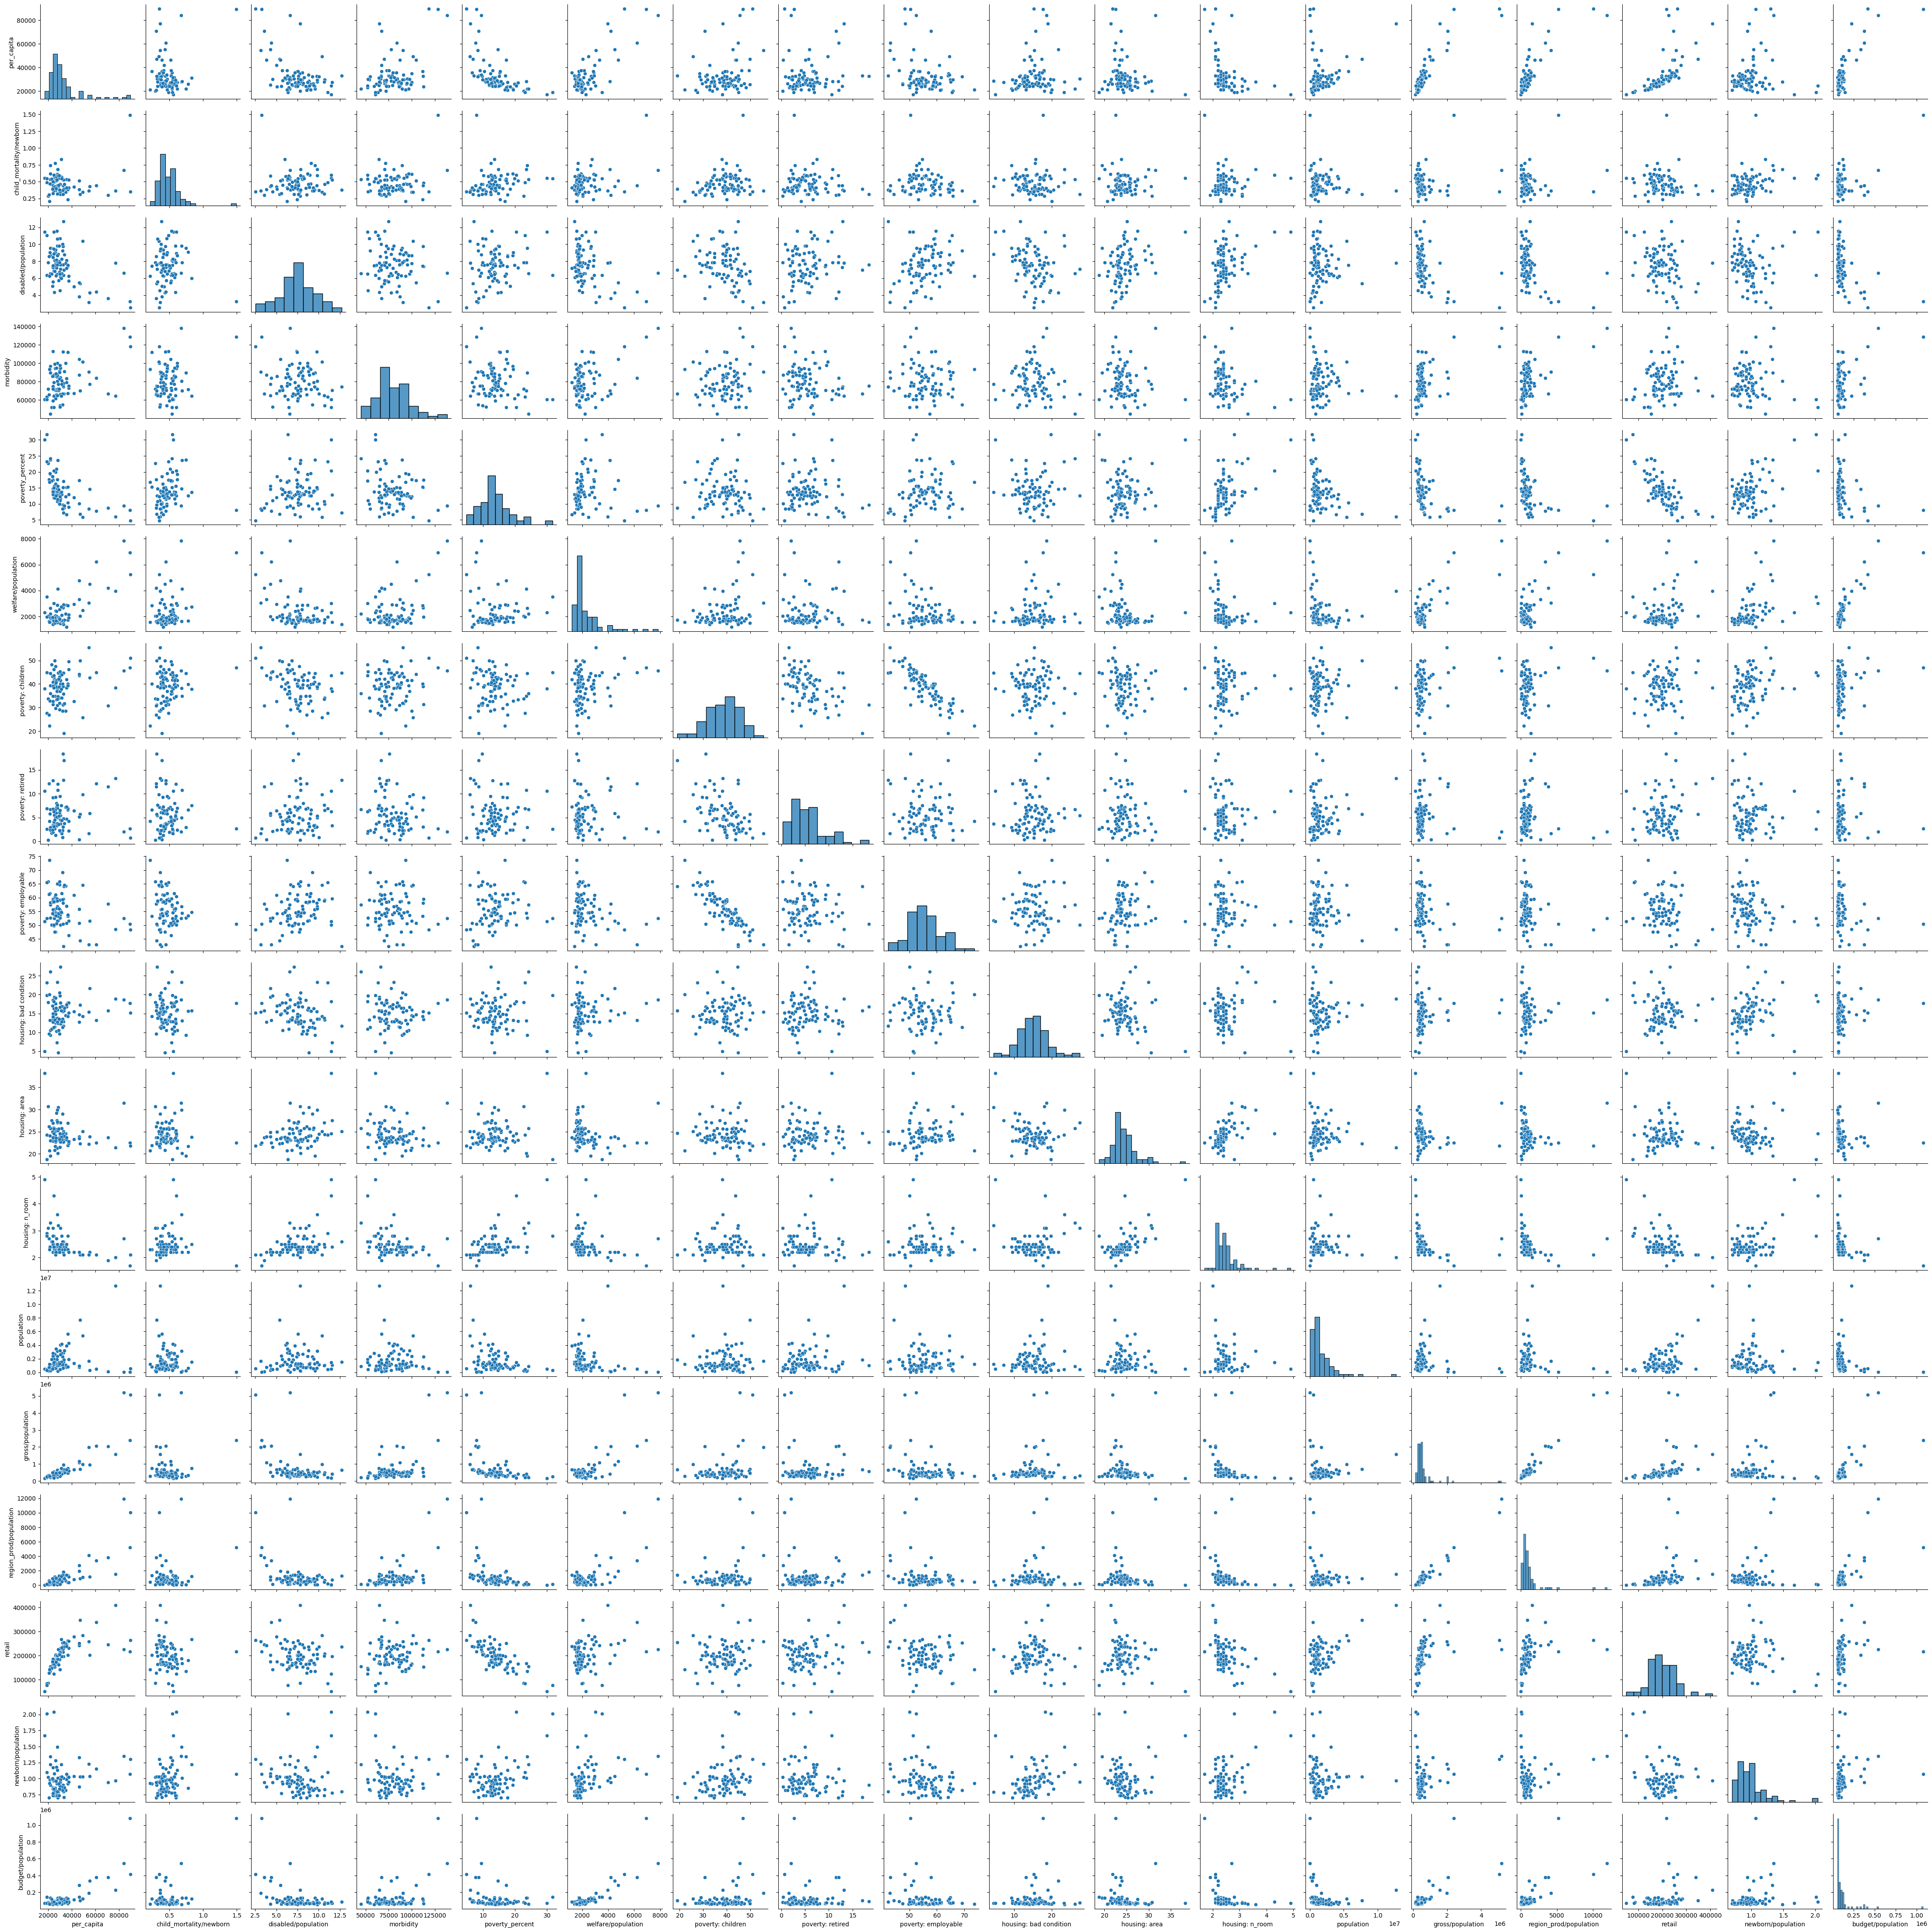

In [28]:
sns.pairplot(df)

Text(0.5, 1.0, 'Корреляция')

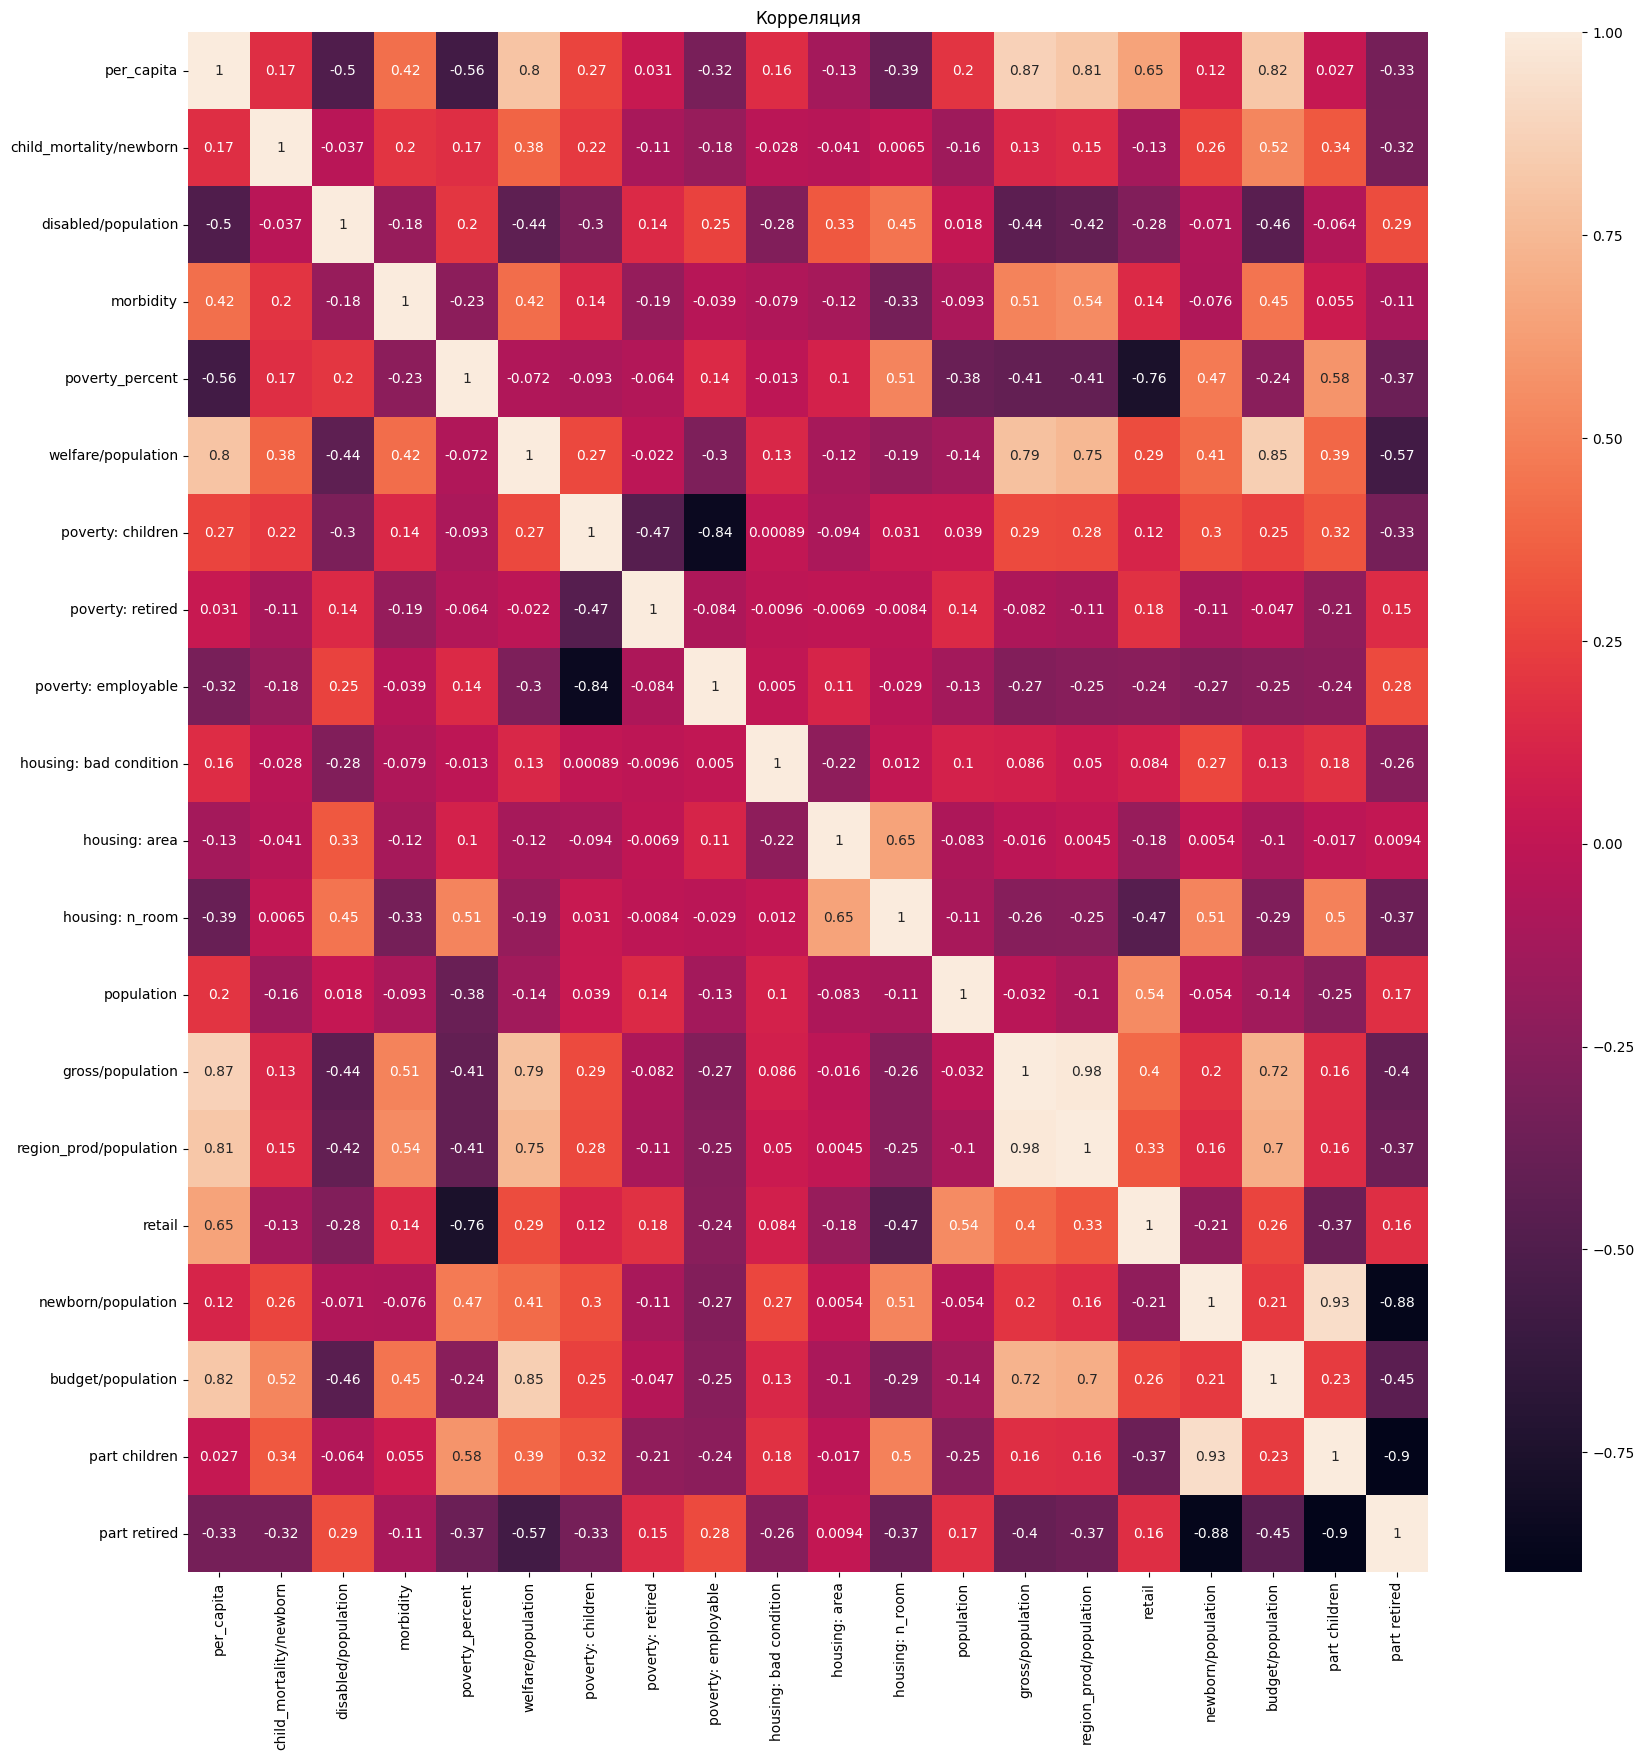

In [49]:
corr = df.corr()
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(corr, annot=True)
ax.set_title('Корреляция')

In [50]:
df.corr()['poverty_percent'].sort_values()

retail                    -0.760910
per_capita                -0.564491
gross/population          -0.411035
region_prod/population    -0.409120
population                -0.379001
part retired              -0.372445
budget/population         -0.241987
morbidity                 -0.227997
poverty: children         -0.092870
welfare/population        -0.071660
poverty: retired          -0.063564
housing: bad condition    -0.013268
housing: area              0.100300
poverty: employable        0.142478
child_mortality/newborn    0.165621
disabled/population        0.204934
newborn/population         0.470177
housing: n_room            0.511726
part children              0.584570
poverty_percent            1.000000
Name: poverty_percent, dtype: float64

Удалим сильно скорелированые признаки

Text(0.5, 1.0, 'Корреляция')

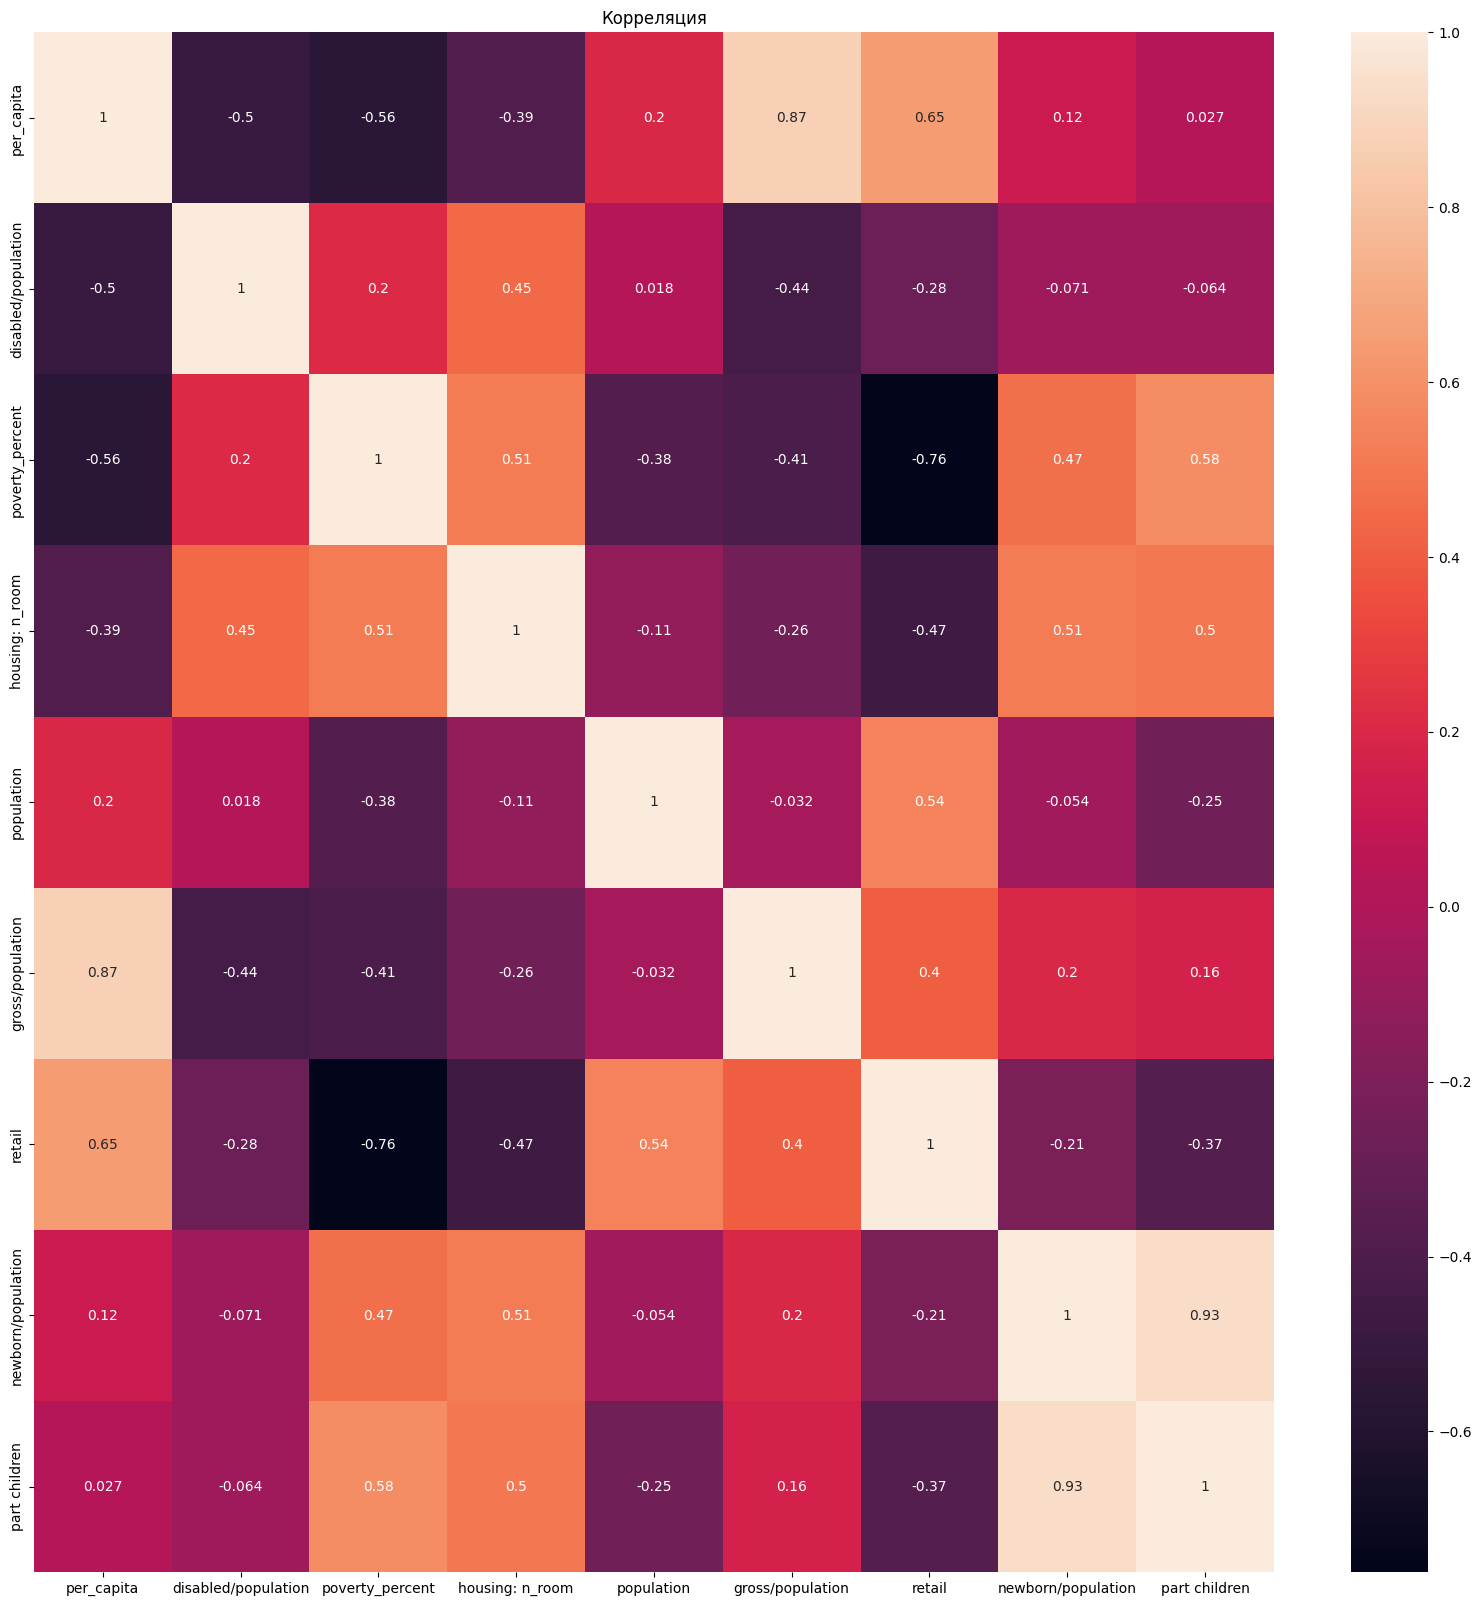

In [51]:
columns_to_drop = [
    'welfare/population', 
    #'gross/population', 
    'region_prod/population', 
    'budget/population', 
    #'retail', 
    #'housing: n_room',
    'poverty: children',
    'morbidity',
    'welfare/population',
    'poverty: retired',
    'housing: bad condition',
    'housing: area',
    'poverty: employable',
    'child_mortality/newborn',
    'part retired'    
    ]

df.drop(columns_to_drop, axis=1, inplace=True)
corr = df.corr()
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(corr, annot=True)
ax.set_title('Корреляция')

### **2.2 Преобразование признаков (нормализация, стандартизация)**

In [34]:
def test_norm(df):
    """Тестирование на нормальность
    returns: l_s - списокстолбцов для нормализации
             l_n- сисок столбцов для стандартизации"""
    l_s = []
    l_n=[]
    for col in df.columns:
        _, p = shapiro(df[col])
        if p>0.05: 
            l_s.append(col)
            print(f'{col}:p-value = {p:.3f}')
        else: l_n.append(col)
    return l_s, l_n
    

In [52]:
l_s, l_n = test_norm(df)

disabled/population:p-value = 0.902


Только три признака имеют нормальное распределение - выполним с ними стандартизацию, с остальными нормализацию. Предварительно попробуем трансформировать распределение с помощью логарифмирования

In [53]:
df[l_n] = np.log(df[l_n])

Посмотрим изменилось ли количесвто признаков с нормальным распределением

In [54]:
l_s, l_n = test_norm(df)

disabled/population:p-value = 0.902
poverty_percent:p-value = 0.520


Стандартизация:

In [55]:
s_scaler = StandardScaler()
df[l_s] = s_scaler.fit_transform(df[l_s])
df[l_s] = pd.DataFrame(df[l_s], columns=l_s)

Нормализация:

In [56]:
mm_scaler = MinMaxScaler()
df[l_n] = mm_scaler.fit_transform(df[l_n])
df[l_n] = pd.DataFrame(df[l_n], columns=l_n)

In [57]:
df.to_csv('data/social_russia_data/social_russia_data_norm.csv')

In [79]:
df = pd.read_csv('data/social_russia_data/social_russia_data.csv', index_col='region')
df.drop(columns_to_drop, axis=1, inplace=True)
mm_scaler = MinMaxScaler()
col=df.columns
ind = df.index
df1= mm_scaler.fit_transform(df)
df1 = pd.DataFrame(df1, columns=col, index=ind)
#df1.index.name='region'
df1.to_csv('data/social_russia_data/social_russia_data_norm1.csv')

In [80]:
df1.index.name#='region'

'region'

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Адыгея, республика to Ярославская область
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   per_capita           85 non-null     float64
 1   disabled/population  85 non-null     float64
 2   poverty_percent      85 non-null     float64
 3   housing: n_room      85 non-null     float64
 4   population           85 non-null     float64
 5   gross/population     85 non-null     float64
 6   retail               85 non-null     float64
 7   newborn/population   85 non-null     float64
 8   part children        85 non-null     float64
dtypes: float64(9)
memory usage: 6.6+ KB


In [82]:
df1.head()

,per_capita,disabled/population,poverty_percent,housing: n_room,population,gross/population,retail,newborn/population,part children
region,,,,,,,,,
"Адыгея, республика",0.183653,0.446576,0.286245,0.43750,0.033163,0.032974,0.504899,0.186567,0.228426
"Алтай, республика",0.065708,0.693231,0.706320,0.21875,0.013936,0.027893,0.236445,0.477612,0.685279
Алтайский край,0.095646,0.480618,0.472119,0.21875,0.179915,0.029414,0.287439,0.119403,0.213198
Амурская область,0.254918,0.547226,0.386617,0.18750,0.059042,0.084746,0.543411,0.216418,0.284264
Архангельская область,0.246061,0.514463,0.278810,0.21875,0.082976,0.073459,0.556820,0.089552,0.197970
